## Imports

In [2]:
# Data Manipulation and Analysis
import numpy as np
import pandas as pd

# Data Split and Cross Validation
from sklearn.model_selection import train_test_split,cross_val_score

# ML Models
from sklearn import svm # Support Vector Machine classifier
from sklearn.neighbors import KNeighborsClassifier # K-Nearest Neighbors classifier
from sklearn.ensemble import RandomForestClassifier # Random Forest classifier
from sklearn.linear_model import LogisticRegression # Logistic Regression classifier


# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim


# Evaluation Metrics and Model Selection
from sklearn.metrics import accuracy_score,roc_auc_score, roc_curve

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Importance
import shap

# Utility Functions
import random
from utils import *

c:\Users\amoha\anaconda3\envs\cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("data/Final.csv").round(4)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,HOMA_IR,Glucose_BMI_Interact,Age_Insulin_Interact,Age_BMI_Interact,Age_Pregnancies_Interact,Insulin_skin_Interact,SkinThickness_to_BMI_Ratio,Family_History,BloodPressure_Category,Age_Group,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,0.0000,4972.8,0.0,1680.0,300.0,0.0,1176.0,1.0,2.0,2.0,1.0
1,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,0.0000,4263.9,0.0,745.6,256.0,0.0,0.0,1.0,2.0,1.0,1.0
2,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,20.6568,2500.9,1974.0,590.1,21.0,2162.0,646.3,0.0,0.0,1.0,0.0
3,3.0,78.0,50.0,32.0,88.0,31.0,0.248,26.0,16.9481,2418.0,2288.0,806.0,78.0,2816.0,992.0,0.0,0.0,1.0,1.0
4,2.0,197.0,70.0,45.0,543.0,30.5,0.158,53.0,264.1259,6008.5,28779.0,1616.5,106.0,24435.0,1372.5,0.0,2.0,2.0,1.0


In [4]:
X = df.drop(columns="Outcome").values
y = df["Outcome"].values

data = df.drop(columns="Outcome")

## Data Split



**Improved Generalisation through Separate Normalisation**


Normalising the training and validation data separately can improve model generalisation in a few ways:

1. **Prevents Data Leakage**: Separately normalising training and validation data prevents information leakage from the validation set into the training process, reducing the risk of overfitting.

2. **Reflects Real-World Variation**: By adapting to the specific characteristics of each dataset, separate normalisation better prepares the model for unseen data with potentially different distributions.

3. **Enhanced Stability**: Separate normalisation ensures that each dataset is scaled appropriately, leading to a more stable training process and better convergence.



In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

### Z-score Normalisation

This technique scales the values of a feature to have a mean of 0 and a standard deviation of 1. This is done by subtracting the mean of the feature from each value, and then dividing by the standard deviation.

In [6]:
# Calculate means and standard deviations
X_train_mean = np.mean(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)

X_test_mean = np.mean(X_test, axis=0)
X_test_std = np.std(X_test, axis=0)

X_val_mean = np.mean(X_val, axis=0)
X_val_std = np.std(X_val, axis=0)

# Z-score Normalisation of train, validation, and test sets
X_train = (X_train - X_train_mean) / X_train_std
X_val = (X_val - X_val_mean) / X_val_std
X_test = (X_test - X_test_mean) / X_test_std

## Model Implementation

In [7]:
num_folds = 5

# Define classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=10000),
    "SVM": svm.SVC(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "RandomFC": RandomForestClassifier(random_state=42)
}

# Cross-validate and train classifiers
cv_scores = {}
test_scores = {}
for name, clf in classifiers.items():
    cv_scores[name] = cross_val_score(clf, X_train, y_train.ravel(), cv=num_folds).mean()
    clf.fit(X_train, y_train)
    test_scores[name] = clf.score(X_test, y_test)

# Find the best model based on cross-validation scores
best_model = max(cv_scores.items(), key=lambda x: x[1])

print(f"Best model based on cross-validation: {best_model[0]}")
print(f"Cross-validation accuracy: {cv_scores[best_model[0]]}")

# Test the best model on the test set
print(f"Test accuracy with {best_model[0]}: {test_scores[best_model[0]]}")


Best model based on cross-validation: RandomFC
Cross-validation accuracy: 0.8975520475863646
Test accuracy with RandomFC: 0.9285714285714286


Based on the printout above, it's evident that the random forest model has achieved the highest cross-validation accuracy. Additionally, the model has demonstrated robust performance on unseen data, with a test accuracy of approximately 93%. To gain deeper insights into the model's behavior and understand the importance of different features, we will employ the SHAP (SHapley Additive exPlanations) technique. SHAP will enable us to examine the impact of each feature on model predictions and provide valuable insights into the model's decision-making process.

### SHapley Additive exPlanations(SHAP)

SHapley Additive exPlanations (SHAP) is a unified framework for explaining the output of any machine learning model. It provides a comprehensive explanation of individual predictions by attributing the model's output to different input features.

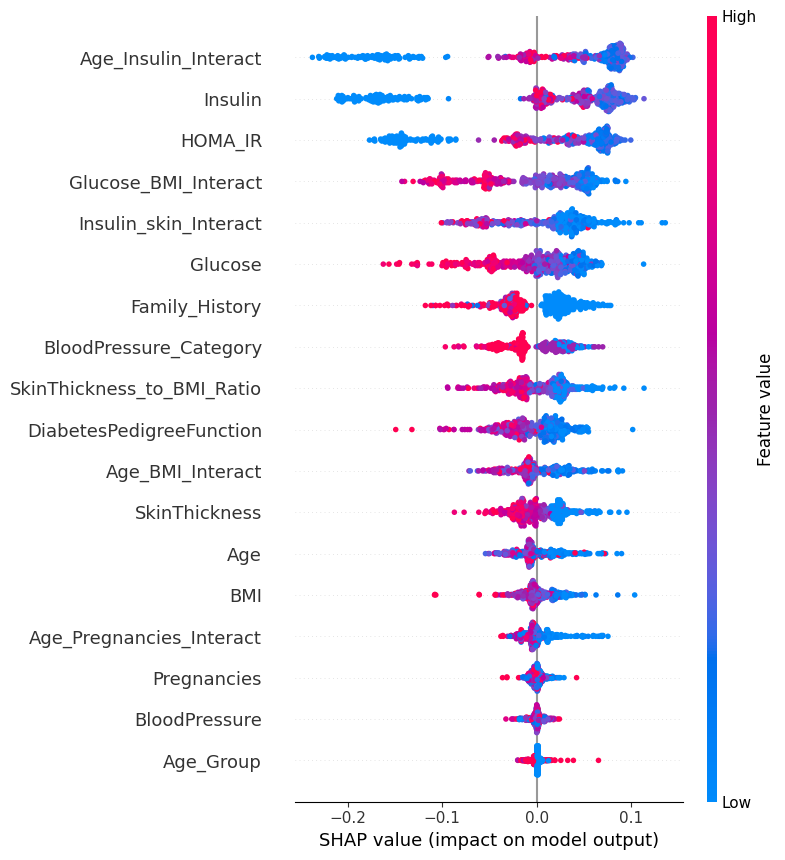

In [8]:
best_model_name = best_model[0]
best_model_object = classifiers[best_model_name]

# Train the best model on the entire training set
best_model_object.fit(X_train, y_train)

# Use SHAP to explain model predictions
explainer = shap.TreeExplainer(best_model_object)
shap_values = explainer.shap_values(X_train)

# Plot SHAP summary plot
shap.summary_plot(shap_values[:,:,0], X_train, feature_names=np.array(df.columns.drop("Outcome")))

The SHAP summary plot reveals the influential features driving our model's predictions. Notably, Low Insulin values and low interaction between age and Insulin values exhibit substantial influence, while features like family history and number of pregnancies have minimal impact. Discarding these less impactful features can effectively reduce computational costs without compromising the model's predictive performance.

## Deep Learning

In this section, we'll explore the application of a sequential model, a simple multilayer perceptron, to assess its suitability for our task. While this approach might be considered overkill for this dataset, given that a random forest model has already achieved an accuracy of 92%, it offers insights into the potential performance and capabilities of deep learning methods for this application.

In [9]:
# Sequential Model

def create_model(n1, n2,num_features):
    model = nn.Sequential(
        nn.Linear(num_features, n1),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(n1, n2),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(n2, 1),
        nn.Sigmoid()
    )
    return model

### PyTorch tensors


In [10]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)


y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

### CUDA

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training

In [25]:
# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

param = {'batch_size': 32, 'lr': 0.001, 'n1': 32, 'n2': 64}
model = create_model(param["n1"], param['n2'], X_train.shape[1]).to(device)

loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=param['lr'])

train, validation, test = train_model(model, X_train, y_train, X_val, y_val, X_test, y_test, optimizer, loss_fn)


Epoch [1/100], Train Loss: 0.6682, Val Loss: 0.6326, Train Accuracy: 7.9402, Val Accuracy: 7.7436
Epoch [2/100], Train Loss: 0.6021, Val Loss: 0.5657, Train Accuracy: 7.9402, Val Accuracy: 7.7436
Epoch [3/100], Train Loss: 0.5401, Val Loss: 0.4948, Train Accuracy: 7.9402, Val Accuracy: 7.7436
Epoch [4/100], Train Loss: 0.4797, Val Loss: 0.4355, Train Accuracy: 7.9402, Val Accuracy: 7.7436
Epoch [5/100], Train Loss: 0.4298, Val Loss: 0.3937, Train Accuracy: 7.9145, Val Accuracy: 7.7436
Epoch [6/100], Train Loss: 0.4009, Val Loss: 0.3688, Train Accuracy: 7.9145, Val Accuracy: 7.7436
Epoch [7/100], Train Loss: 0.3602, Val Loss: 0.3527, Train Accuracy: 7.8889, Val Accuracy: 7.7436
Epoch [8/100], Train Loss: 0.3501, Val Loss: 0.3436, Train Accuracy: 7.9145, Val Accuracy: 7.7436
Epoch [9/100], Train Loss: 0.3594, Val Loss: 0.3353, Train Accuracy: 7.8889, Val Accuracy: 7.7436
Epoch [10/100], Train Loss: 0.3343, Val Loss: 0.3353, Train Accuracy: 7.9145, Val Accuracy: 7.7436
Epoch [11/100], Tra

c:\Users\amoha\anaconda3\envs\cuda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amoha\anaconda3\envs\cuda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amoha\anaconda3\envs\cuda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model Performance Evaluation

TypeError: list indices must be integers or slices, not str

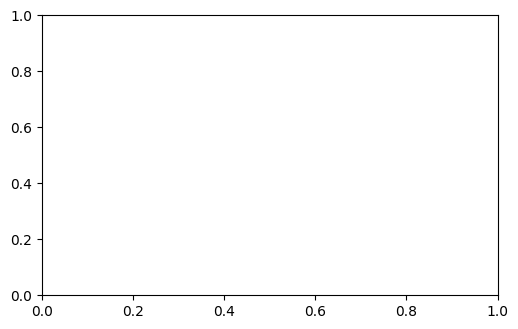

In [27]:
metrics = ['Loss', 'Accuracy', 'F1 Score', 'Precision', 'Recall']
plt.figure(figsize=(20, 8))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    plt.plot(train[metric], label='Train')
    plt.plot(validation[metric], label='Validation')
    plt.plot(test[metric], label='Test')
    plt.title(metric)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    print(i,metric)

plt.tight_layout()
plt.show()


Confusion Matrix - Training Set:


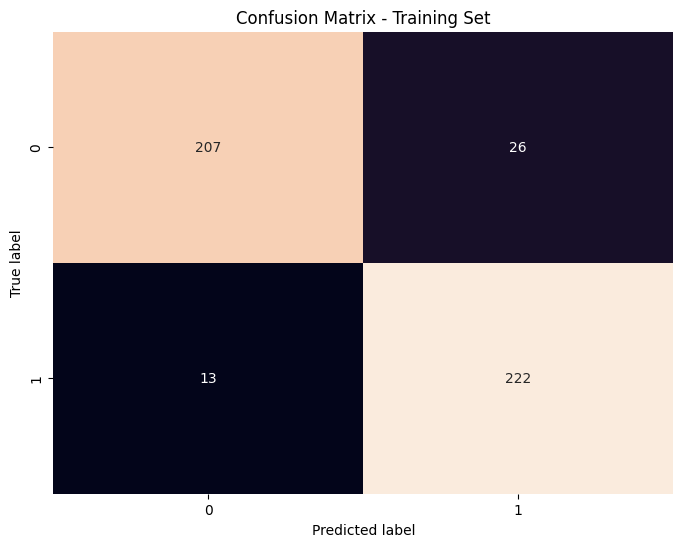

Confusion Matrix - Validation Set:


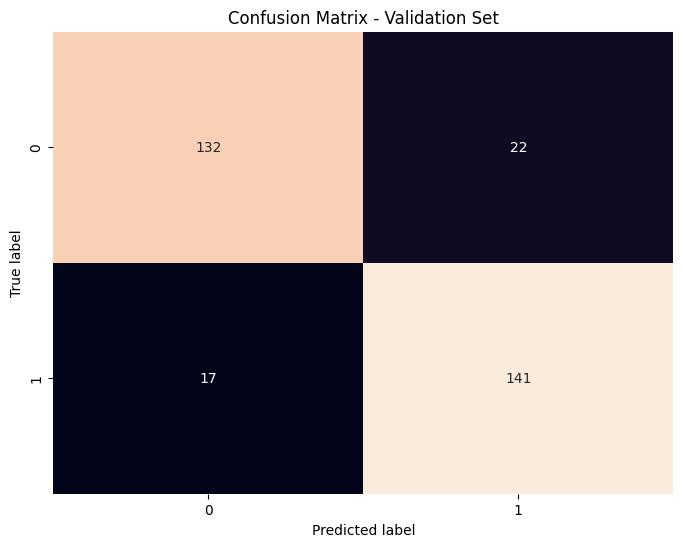

Confusion Matrix - Test Set:


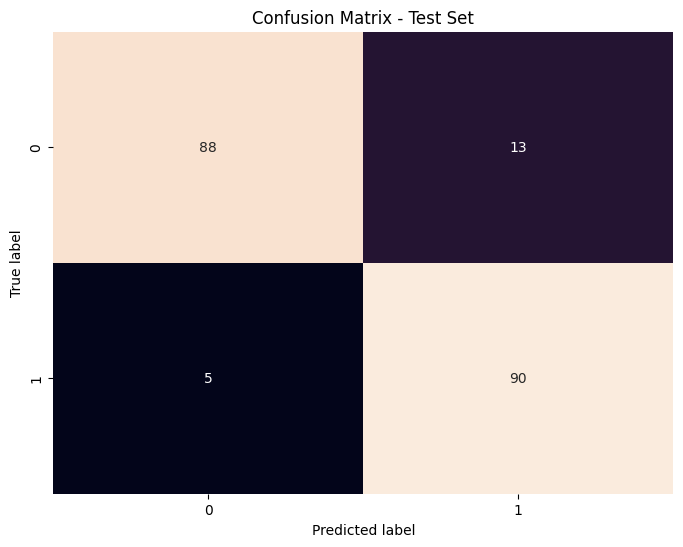

In [21]:
print("Confusion Matrix - Training Set:")
plot_confusion_matrix(train["cm"], title='Confusion Matrix - Training Set')

print("Confusion Matrix - Validation Set:")
plot_confusion_matrix(validation["cm"], title='Confusion Matrix - Validation Set')

print("Confusion Matrix - Test Set:")
plot_confusion_matrix(test["cm"], title='Confusion Matrix - Test Set')


### RPC Curve

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

- True Positive Rate
- False Positive Rate

True Positive Rate (or recall) is defined as:

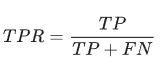

False Positive Rate (FPR) is defined as:

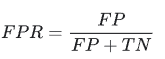


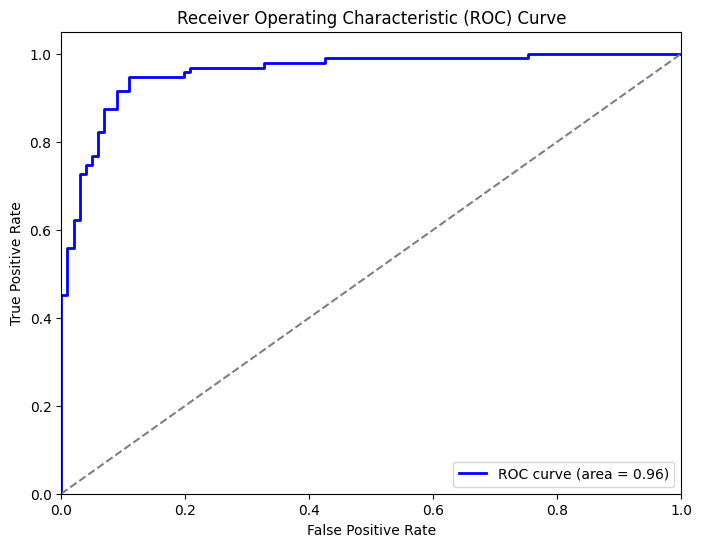

In [30]:
model.eval()
with torch.no_grad():
    # Compute predictions for test set
    y_pred_test = model(X_test.to(device))
    test_loss = loss_fn(y_pred_test, y_test.to(device)).item()
    test_accuracy = accuracy_score(y_test.cpu().numpy(), y_pred_test.round().cpu().numpy())
    roc_auc = roc_auc_score(y_test.cpu(), y_pred_test.cpu())



# Plotting ROC curve
fpr, tpr, thresholds = roc_curve(y_test.cpu().numpy(), y_pred_test.cpu().numpy())
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



The performance analysis of the multi-layer perceptron (MLP) reveals noteworthy results:

- **Average Accuracy**: Achieves an impressive 90% on both validation and test datasets.
- **AUC**: Attains a high value of 0.96, indicating robust performance.

However, a potential concern arises as the model appears to exhibit signs of overfitting after epoch 30. Despite this, the discrepancy between the training accuracy and that of other datasets is minimal, suggesting effective generalisation. 

### Analysing Feature Importance

In the subsequent section, we will delve into analysing feature importance. This exploration aims to provide deeper insights into the model's behavior and decision-making process.


## Feature Importance

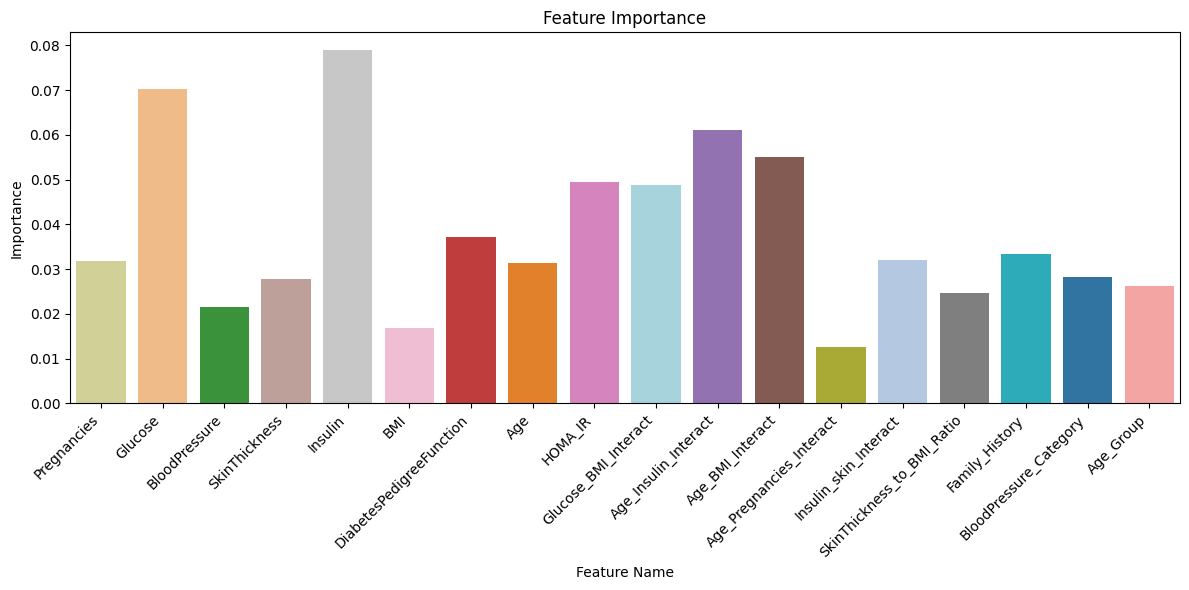

In [ ]:
# Calculate feature importance
feature_importance = calculate_feature_importance(model, X_train)


# Assuming you have already defined feature_names and feature_importance

palette1 = sns.color_palette("tab10", n_colors=10)
palette2 = sns.color_palette("tab20", n_colors=20)

# Combine the two palettes to get 18 distinct colors
colors = list(set(palette1 + palette2))

plt.figure(figsize=(12, 6))  # Increase the width of the figure
ax = sns.barplot(x=data.columns, y=feature_importance, palette=colors[:18],hue = data.columns)

plt.xlabel('Feature Name')
plt.ylabel('Importance')
plt.title('Feature Importance')

# Rotate x-axis labels to an angle for better readability
ax.set_xticks(range(len(data.columns)))
ax.set_xticklabels(data.columns, rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to improve spacing
plt.show()


The analysis of feature importance for our MLP model reveals intriguing insights:

1. **Insulin**: Emerges as the most influential feature.
2. **Glucose**:  Holds the second position in terms of importance.
3. **Age Insulin Interact**: Secures the third spot in the hierarchy of influential features.

Conversely, **BMI** and the **interaction between age and pregnancies** are identified as the least influential features. This understanding provides valuable insights into the factors driving the model's predictions, guiding further analysis and refinement.

### Streamlining the Model

This insight into feature importance empowers us to streamline our model by focusing solely on the most influential features. By incorporating only these significant factors, we can effectively reduce computational complexity and training time. Consequently, this streamlined approach yields a faster and simpler model without significantly compromising accuracy.



In [ ]:
importance_dict = {'importance':feature_importance,'feature':data.columns}

# Create a dictionary where keys are feature names and values are importance scores
feature_importance_dict = dict(zip(importance_dict['feature'], importance_dict['importance']))

# Sort the dictionary by importance scores in descending order
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Select the top features with the highest importance scores
top10_features = sorted_features[:10] 

# Print the top features
print("Top features with highest importance:")
for feature, importance in top10_features:
    print(f"{feature}: {importance}")


Top features with highest importance:
Insulin: 0.0789504423737526
Glucose: 0.07032755017280579
Age_Insulin_Interact: 0.06115948036313057
Age_BMI_Interact: 0.054991353303194046
HOMA_IR: 0.04934576153755188
Glucose_BMI_Interact: 0.048706233501434326
DiabetesPedigreeFunction: 0.03723517060279846
Family_History: 0.03340919315814972
Insulin_skin_Interact: 0.032040148973464966
Pregnancies: 0.03175469860434532


## Hyper Parameter Tuning (Grid Search)
By systematically exploring various hyperparameter combinations, grid search helps us identify the optimal configuration for our model, leading to improved performance and better generalisation.



### Grid Search Parameters
- **Batch Size**: We will experiment with batch sizes of 8, 16, 32, and 64.
- **Learning Rate (lr)**: We will evaluate learning rates of 0.001, 0.01, and 0.1.
- **Hidden Layer Sizes (n1 and n2)**: We will vary the number of neurons in the two hidden layers with options of 16, 32, 64 and 128 for each layer.


In [ ]:
# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Define the grid search parameters
grid_params = {
    'batch_size': [8, 16, 32, 64],
    'lr': [0.001, 0.01, 0.1],
    'n1': [16, 32, 64, 128],
    'n2': [16, 32, 64, 128]
}

X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

best_params = grid_search(X_train, y_train, X_val, y_val, X_test, y_test, grid_params)

best_val_loss = float('inf')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\nBest Parameters:", best_params)




Early stopping at epoch 73 for parameter combination: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 16}

Parameters: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 16}, Best Validation Loss: 0.3055, Val_acc: 0.8717948794364929 at epoch 53

Early stopping at epoch 20 for parameter combination: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 32}

Parameters: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 32}, Best Validation Loss: 0.3055, Val_acc: 0.8589743971824646 at epoch 53

Early stopping at epoch 20 for parameter combination: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 64}

Parameters: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 64}, Best Validation Loss: 0.3055, Val_acc: 0.8589743971824646 at epoch 53

Early stopping at epoch 20 for parameter combination: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 128}

Parameters: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 128}, Best Validation Loss: 0.3055, Val_acc: 0.8589743971824646 at epoch 53

Early stopping at epoch 20 for pa


### Observations:

Following a grid search of parameters, we have identified the optimal settings for our model:

- **Batch size:** 32
- **Learning rate (lr):** 0.01
- **Number of neurons in the first hidden layer (n1):** 16
- **Number of neurons in the second hidden layer (n2):** 128

Employing these parameters will enable us to develop the best-performing model.

### Future Directions

Looking ahead, our focus should center on two key areas:

1. **Expanding the Dataset**: Increasing the dataset with additional observations is crucial. This expansion will bolster the model's ability to generalise to unseen data, thereby enhancing overall accuracy.

2. **Clarifying Assumptions Regarding Data Issues/Errors**: Gaining a deeper understanding of potential issues or errors in the data will contribute to refining the model's performance and reliability.

### Deployment Considerations

In addition to refining the model, we must also consider its deployment:

- **Establishing a Robust Deployment Strategy**: Ensuring the model's accessibility and usability in real-world scenarios is paramount. This involves integrating the model into existing systems or platforms.
- **Thorough Testing**: Conducting rigorous testing to validate its performance in production environments.
- **Implementing Monitoring and Maintenance Mechanisms**: Setting up mechanisms for ongoing monitoring and maintenance will ensure the model remains effective over time.

By addressing these deployment considerations, we can effectively transition our model from development to practical application, maximising its impact and utility.

